# Задачи


In [2]:
import pandas as pd
import gurobipy as gp
from gurobipy import GRB


## Банкови заеми

Банка е в процеса на определяне на кредитната си политика за пет
различни сектора с характеристики дадени в следната таблица:

| Вид кредит      | Лихва | Дял на несъбираеми кредити |
|-----------------|------:|---------------------------:|
| Потребителски   |  0.15 |                       0.10 |
| Автомобили      |  0.13 |                       0.07 |
| Недвижими имоти |  0.12 |                       0.03 |
| Земеделие       | 0.125 |                       0.05 |
| Търговия        |  0.10 |                       0.02 |

Банката разполага с общо 12 милиона лева и при определяне на политиката
трябва да се съобрази със следните регулации:

1. Поне 40% от заемите трябва да са за земеделие или търговия.
2. Заеми за недвижими имоти трябва да са поне половината от общата сума на потребителски кредити, кредити свързани с автомобили и недвижими имоти.
3. По силата на регулаторни изисквания дялът на несъбираемите кредити не трябва да надвишава 4% от всички кредити. Несъбираемите кредити не носят лихви.

Какъв е оптималният (най-висока печалба) план за банката?

:::{.callout-note collapse="true"}
## Математически модел

$$
\begin{align*}
x_{п} & : \text{потребителски кредити в млн. лв.} \\
x_{а} & : \text{кредити за автомобили в млн. лв.} \\
x_{н} & : \text{жилищни кредити (недвижими имоти) в млн. лв.} \\
x_{з} & : \text{земеделски кредити в млн. лв.} \\
x_{т} & : \text{търговски кредити в млн. лв.}
\end{align*}
$$

Отчитайки, че несъбираемите кредити не носят лихви, общата лихва възлиза на

$$
\begin{align*}
\text{лихви} = & 0.15(1 - 0.1)x_{п} + \\
               & 0.13(1 - 0.07)x_{а} + \\
               & 0.12(1 - 0.03)x_{н} + \\
               & 0.125(1 - 0.05)x_{з} + \\
               & 0.10(1 - 0.02)x_{т}
\end{align*}
$$

Несъбираемите кредити възлизат на 

$$
x_{\text{несъбираеми}} = 0.10x_{п} + 0.07x_{а} + 0.03x_{н} + 0.05x_{з} + 0.02x_{т}
$$

Целевата функция е разликата от лихвите и несъбираемите кредити

$$
\max \text{лихви} - x_{\text{несъбираеми}}
$$

Ограниченията в задачата са 5:

1. Общият обем на отпуснатите кредити да не надвишава 12 млн. лв.

$$
x_\text{общо} = x_{п} + x_{а} + x_{н} + x_{з} + x_{т} \leq 12
$$

2. Поне 40% от кредитите да са насочени към търговския сектор

$$
x_{т} + x_{з} \geq 0.4x_\text{общо}
$$

3. Кредитите за недвижими имоти да са поне половината от общата сума на потребителски кредити, кредити свързани с автомобили и недвижими имоти

$$
x_{н} \geq \frac{1}{2}(x_{п} + x_{а} + x_{н})
$$

4. Дялът на несъбираемите кредити не трябва да надвишава 4% от всички кредити

$$
x_{\text{несъбираеми}} \leq 0.04x_\text{общо}
$$

5. Неотрицателност на кредитите

$$
x_{п}, x_{а}, x_{н}, x_{з}, x_{т} \geq 0
$$

:::


In [3]:
# Create a new model
m = gp.Model("mip1")
m.params.LogToConsole = 0

# Create variables
x_cons = m.addVar(name="Consumer")
x_auto = m.addVar(name="Automobile")
x_home = m.addVar(name="Home")
x_agri = m.addVar(name="Agriculture")
x_comm = m.addVar(name="Commercial")

# Set objective

interest = 0.015 * (1 - 0.1) * x_cons + 0.13 * (1 - 0.07) * x_auto + 0.12 * (1 - 0.03) * x_home + 0.125 * (
            1 - 0.05) * x_agri + 0.1 * (1 - 0.02) * x_comm
defaults = 0.1 * x_cons + 0.07 * x_auto + 0.03 * x_home + 0.05 * x_agri + 0.02 * x_comm

m.setObjective(interest - defaults, GRB.MAXIMIZE)

# Constraints

x_all = gp.quicksum([x_cons, x_auto, x_home, x_agri, x_comm])

m.addConstr(x_all <= 12, "Credit Limit")
m.addConstr(x_agri + x_comm >= 0.4 * x_all, "Agriculture and Commercial Loans >= 40%")
m.addConstr(x_home >= 0.5 * (x_cons + x_auto + x_home), "Home Loans >= 50% of Consumer, Automobile, and Home Loans")
m.addConstr(defaults <= 0.04 * x_all, "Defaults <= 4% of Total Loans")

m.optimize()

vars_df = pd.DataFrame(columns=["Variable", "Value", "RC"], data=[(var.varName, var.x, var.RC) for var in m.getVars()])
constr_df = pd.DataFrame(columns=["Constraint", "Slack", "Dual"],
                         data=[(constr.constrName, constr.slack, constr.pi) for constr in m.getConstrs()])


Restricted license - for non-production use only - expires 2025-11-24


In [4]:
#| label: tbl-bank-loans-variables
#| tbl-cap: "Стойности на променливите в оптимума за банковите заеми"

vars_df

,Variable,Value,RC
0,Consumer,0.0,-0.17290
1,Automobile,0.0,-0.03550
2,Home,7.2,0.00000
3,Agriculture,0.0,-0.00925
4,Commercial,4.8,0.00000


In [5]:
#| label: tbl-bank-loans-constraints
#| tbl-cap: "Ограничения за банковите заеми в оптимума за банковите заеми"

constr_df

,Constraint,Slack,Dual
0,Credit Limit,0.000,0.08304
1,Agriculture and Commercial Loans >= 40%,0.000,-0.00840
2,"Home Loans >= 50% of Consumer, Automobile, and...",-3.600,0.00000
3,Defaults <= 4% of Total Loans,0.168,0.00000


## Планиране на градско строителство

Да приемем, че София е изправена пред дефицит в местния бюджет и общинският съвет обмисля как да увеличи приходите от данък сгради чрез преустройства на общински имоти. Проектът се състои от две части -- разчистване на занемарени и повредени постройки и построяване на нови жилища.

1. В момента на планиране общината притежава 300 занемарени постройки, които могат да бъдат съборени. Всяка от тях освобождава 1000 кв. метра и събарянето й струва 3 000 лв. на постройка. 15 процента от освободеното пространство е предвидено за улици, тротоари и свободни  пространства.
2. На освободените парцели общината може да построи четири вида нови жилищни сгради: еднофамилни (300 кв. метра), двуфамилни (500 кв. метра), три-фамилни (700 кв. метра) и четири-фамилни къщи (900 кв. метра). Очакваните данъчни постъпления са съответно 1 000 лв., 1 700 лв., 2 400 лв. и 2 800 лв. на година.
3. Поне 20 процента от новите постройки трябва да са еднофамилни къщи, двуфамилните домове трябва да съставляват поне 20 процента, а три и четири-фамилните домове трябва (заедно) да са поне една четвърт от всички нови постройки.
4. Строителните разходи за новите домове са съответно 50 000 лв., 70 000 лв., 130 000 лв. и 160 000 лв.
5. Общината предвижда на финансира проекта чрез банков заем, който не може да надвишава 15 милиона лева.

Колко от всеки вид къщи трябва да планира да построи общината, така че да постигне възможно най-високи данъчни постъпления?

:::{.callout-note collapse="true"}
## Математически модел

Променливи

$$
\begin{align*}
x_{single} & : \text{брой еднофамилни къщи} \\
x_{double} & : \text{брой двуфамилни къщи} \\
x_{triple} & : \text{брой трифамилни къщи} \\
x_{quad} & : \text{брой четирифамилни къщи} \\
x_{dem} & : \text{брой съборени постройки}
\end{align*}
$$

Целева функция (в хиляди лева)

$$
\max x_{single} + 1.7x_{double} + 2.4x_{triple} + 2.8x_{quad}
$$

Ограничения

1. Площ

$$
300x_{single} + 500x_{double} + 700x_{triple} + 900x_{quad} x_{dem} \leq (1 - 0.15) \cdot 1000 \cdot x_{dem}
$$

2. Брой съборени постройки

$$
x_{dem} \leq 300
$$

3. Съотношения между видовете нови къщи
$$
x_{all} = x_{single} + x_{double} + x_{triple} + x_{quad}
$$

$$
\begin{align*}
x_{single} \geq 0.2 x_{all} \\
x_{double} \geq 0.2 x_{all} \\
x_{tripple} + x_{quad} \geq 0.25 x_{all}
\end{align*}
$$

4. Финансови ограничения (в хиляди лева)
$$
50x_{single} + 70x_{double} + 130x_{triple} + 160x_{quad} + 3x_{dem} \leq 15000
$$

:::


In [6]:
#| fold-code: true

m = gp.Model("Urban Planning")
m.params.LogToConsole = 0

# Create variables
single = m.addVar(name="Single")
dbl = m.addVar(name="Double")
trpl = m.addVar(name="Triple")
quad = m.addVar(name="Quadruple")
dem = m.addVar(name="Demolished")

# Set objective
m.setObjective(single + 1.7 * dbl + 2.4 * trpl + 2.8 * quad, GRB.MAXIMIZE)

# Add constraints
m.addConstr(300 * single + 500 * dbl + 700 * trpl + 900 * quad - 850 * dem <= 0, "Area")
m.addConstr(dem <= 300, "Demolitions")
m.addConstr(-0.8 * single + 0.2 * dbl + 0.2 * trpl + 0.2 * quad <= 0, "Single")
m.addConstr(0.1 * single - 0.9 * dbl + 0.1 * trpl + 0.1 * quad <= 0, "Double")
m.addConstr(0.25 * single + 0.25 * dbl - 0.75 * trpl - 0.75 * quad <= 0, "Triple/Quadruple")
m.addConstr(50 * single + 70 * dbl + 130 * trpl + 160 * quad + 3 * dem <= 15000, "Budget")

# Optimize model
m.optimize()

# Print results
print('Model Status:', m.status)
print('Objective:', m.objVal)

var_df = pd.DataFrame(columns=['Variable', 'Value', 'RC'], data=[(v.VarName, v.X, v.RC) for v in m.getVars()])
constr_df = pd.DataFrame(columns=['Constraint', 'Shadow Price', 'Lower', 'Upper'],
                         data=[(c.ConstrName, c.Pi, c.SARHSLow, c.SARHSUp) for c in m.getConstrs()])


Model Status: 2
Objective: 314.3115942028985


In [7]:
#| label: tbl-urban-planning-variables
#| tbl-cap: "Стойности на променливите в оптимума за градското строителство"
var_df

,Variable,Value,RC
0,Single,36.231884,0.000000
1,Double,99.637681,0.000000
2,Triple,45.289855,0.000000
3,Quadruple,0.000000,-0.243414
4,Demolished,108.695652,0.000000


In [8]:
#| label: tbl-urban-planning-constraints
#| tbl-cap: "Ограничения за градското строителство в оптимума за градското строителство"

constr_df

,Constraint,Shadow Price,Lower,Upper
0,Area,0.000074,-166222.222222,9.444444e+04
1,Demolitions,0.000000,108.695652,inf
2,Single,0.266127,-91.858790,3.450609e+01
3,Double,0.000000,-81.521739,inf
4,Triple/Quadruple,0.572038,-61.298077,5.545407e+01
5,Budget,0.020954,0.000000,4.140000e+04




## Производство и неустойки

Малък шивашки цех се опитва да определи производствения си план за следващия сезон. Цехът произвежда
четири продукта: якета, шапки, ръкавици и панталони, които се произвеждат в четири отделения: рязане, уплътняване, шиене и пакетиране.


| Отделения/продукти | Якета | Шапки | Ръкавици | Панталони | Капацитет (часове) |
|--------------------|------:|------:|---------:|----------:|-------------------:|
| Рязане             |   0.3 |   0.3 |     0.25 |      0.15 |               1000 |
| Уплътняване        |  0.25 |  0.35 |      0.3 |      0.10 |               1000 |
| Шиене              |  0.45 |   0.5 |      0.4 |      0.22 |               1000 |
| Пакетиране         |  0.12 |  0.15 |      0.1 |      0.05 |               1000 |


Цехът вече има получени поръчки за четирите продукта. Договорите за производство включват неустойка за всяка недоставена единица:

| Отделения/продукти   | Якета | Шапки | Ръкавици | Панталони |
|----------------------|------:|------:|---------:|----------:|
| Поръчки (брой)       |   800 |   750 |      600 |       600 |
| Печалба (лв./брой)   |    30 |    40 |       20 |        10 |
| Неустойка (лв./брой) |    15 |    20 |       10 |         8 |


Намерете оптималния производствен план за този цех.

:::{.callout-note collapse="true"}
## Математически модел

$$
\begin{align}
x_{jackets} & : \text{брой якета} \\
x_{hats} & : \text{брой шапки} \\
x_{gloves} & : \text{брой ръкавици} \\
x_{pants} & : \text{брой панталони}
\end{align}
$$

Общата печалба от производството е равна на печалбата от продажбата на 
минус разходите за неустойки:

Печалбата от продажба е равна на количествата произведени продукти умножени по цената на единица:

$$
\text{profit (sale)} = 30x_{jackets} + 40x_{hats} + 20x_{gloves} + 10x_{pants}
$$

Разходите за неустойки се определят от разликата между поръчките и произведените продукти:

$$
\begin{align}
x_{jackets} + s_{jackets} = 800 \\
x_{hats} + s_{hats} = 750 \\
x_{gloves} + s_{gloves} = 600 \\
x_{pants} + s_{pants} = 600
\end{align}
$$

където $s_{jackets}$, $s_{hats}$, $s_{gloves}$ и $s_{pants}$ са разликите между произведени и поръчани продукти. Общата неустойка е равна на сбора от неустойките за всеки продукт:

$$
\text{penalty} = 15s_{jackets} + 20s_{hats} + 10s_{gloves} + 8s_{pants}
$$

В задачата има още и ограничения за капацитета на отделенията:

$$
0.3 x_{jackets} + 0.3 x_{hats} + 0.25 x_{gloves} + 0.15 x_{pants} \leq 1000 \\
0.25 x_{jackets} + 0.35 x_{hats} + 0.3 x_{gloves} + 0.10 x_{pants} \leq 1000 \\
0.45 x_{jackets} + 0.5 x_{hats} + 0.4 x_{gloves} + 0.22 x_{pants} \leq 1000 \\
0.12 x_{jackets} + 0.15 x_{hats} + 0.1 x_{gloves} + 0.05 x_{pants} \leq 1000
$$

Накрая има и ограничения за неотрицателност на променливите:

$$
\begin{align*}
x_{jackets}, x_{hats}, x_{gloves}, x_{pants} \geq 0 \\
s_{jackets}, s_{hats}, s_{gloves}, s_{pants} \geq 0
\end{align*}
$$

:::



In [9]:
# Create a new model
m = gp.Model("Production and Penalty")
m.Params.LogToConsole = 0

# Create variables
jackets = m.addVar(name="Jackets")
hats = m.addVar(name="Hats")
gloves = m.addVar(name="Gloves")
pants = m.addVar(name="Pants")

# Set objective

profit_sales = 30 * jackets + 40 * hats + 20 * gloves + 10 * pants

# The deficit of jackets, hats, gloves and pants

jackets_deficit = 800 - jackets
hats_deficit = 750 - hats
gloves_deficit = 600 - gloves
pants_deficit = 600 - pants

penalty = 15 * jackets_deficit + 20 * hats_deficit + 10 * gloves_deficit + 8 * pants_deficit

m.setObjective(profit_sales - penalty, GRB.MAXIMIZE)

# Constraints

# The production of jackets, hats, gloves and pants

m.addConstr(0.3 * jackets + 0.3 * hats + 0.25 * gloves + 0.15 * pants <= 1000, "Cutting")
m.addConstr(0.25 * jackets + 0.35 * hats + 0.3 * gloves + 0.1 * pants <= 1000, "Sewing")
m.addConstr(0.45 * jackets + 0.5 * hats + 0.4 * gloves + 0.22 * pants <= 1000, "Sealing")
m.addConstr(0.12 * jackets + 0.15 * hats + 0.1 * gloves + 0.05 * pants <= 1000, "Packaging")

m.optimize()

var_df = pd.DataFrame(columns=['Variable', 'Value', 'RC'], data=[(v.VarName, v.X, v.RC) for v in m.getVars()])
constr_df = pd.DataFrame(columns=['Constraint', 'Shadow Price', 'Lower', 'Upper'],
                         data=[(c.ConstrName, c.Pi, c.SARHSLow, c.SARHSUp) for c in m.getConstrs()])



In [10]:
#| label: tbl-production-penalty-variables
#| tbl-cap: "Стойности на променливите в оптимума за производство и неустойки"

var_df

,Variable,Value,RC
0,Jackets,0.0,-9.0
1,Hats,2000.0,0.0
2,Gloves,0.0,-18.0
3,Pants,0.0,-8.4


In [11]:
#| label: tbl-production-penalty-constraints
#| tbl-cap: "Ограничения за производство и неустойки в оптимума за производство и неустойки"

constr_df

,Constraint,Shadow Price,Lower,Upper
0,Cutting,0.0,600.0,inf
1,Sewing,0.0,700.0,inf
2,Sealing,120.0,0.0,1428.571429
3,Packaging,0.0,300.0,inf


## Производство и склад

Компания за производство на дограма има договор за доставка на дървени дограми за следващите 6 месеца. За същия период компанията очаква разходите за производство (труд и материали) да варират. Компанията може да се възползва от по-ниски производствени разходи в даден период и да произведе повече дограми от необходимото, като разходите за складиране на продуктите са 8 лв. на месец на брой. В момента на планиране фирмата няма готови дограми на склад. В края на периода за планиране компанията изисква да няма дограми на склад.

|                                   | Януари | Февруари | Март | Април | Май | Юни |
|-----------------------------------|-------:|---------:|-----:|------:|-----|-----|
| Поръчки (брой)                    |    100 |      250 |  190 |   140 | 220 | 110 |
| Производствени разходи (лв./брой) |     50 |       45 |   55 |    48 | 52  | 50  |


Формулирайте оптимизационна задача, която да намери оптималния производствен план.

:::{.callout-note collapse="true"}
## Математически модел

$$
\begin{align*}
x_{jan} & : \text{брой дограми произведени през януари} \\
x_{feb} & : \text{брой дограми произведени през февруари} \\
x_{mar} & : \text{брой дограми произведени през март} \\
x_{apr} & : \text{брой дограми произведени през април} \\
x_{may} & : \text{брой дограми произведени през май} \\
x_{jun} & : \text{брой дограми произведени през юни} \\
\end{align*}
$$

$$
\begin{align*}
y_{jan} & : \text{брой дограми на склад в края на януари} \\
y_{feb} & : \text{брой дограми на склад в края на февруари} \\
y_{mar} & : \text{брой дограми на склад в края на март} \\
y_{apr} & : \text{брой дограми на склад в края на април} \\
y_{may} & : \text{брой дограми на склад в края на май} \\
y_{jun} & : \text{брой дограми на склад в края на юни}
\end{align*}
$$

Общите производствени разходи са равни на сбора от произведените дограми умножен по цената на единица:

$$
\text{production cost} = 50x_{jan} + 45x_{feb} + 55x_{mar} + 48x_{apr} + 52x_{may} + 50x_{jun}
$$

Разходите за складиране са равни на сбора от дограмите на склад умножен по цената на единица:

$$
\text{storage cost} = 8y_{jan} + 8y_{feb} + 8y_{mar} + 8y_{apr} + 8y_{may} + 8y_{jun}
$$

За всеки период моделът трябва да гарантира, че броят произведени дограми е равен на продадените и разликата в складираните дограми.

$$
\begin{align*}
x_{jan} + (0  - y_{jan}) & = 100 \\
x_{feb} + (y_{jan} - y_{feb}) & = 250 \\
x_{mar} + (y_{feb} - y_{mar}) & = 190 \\
x_{apr} + (y_{mar} - y_{apr}) & = 140 \\
x_{may} + (y_{apr} - y_{may}) & = 220 \\
x_{jun} + (y_{may} - 0) & = 110
\end{align*}
$$

Накрая има и ограничения за неотрицателност на променливите:

$$
\begin{align*}
x_{jan}, x_{feb}, x_{mar}, x_{apr}, x_{may}, x_{jun} & \geq 0 \\
y_{jan}, y_{feb}, y_{mar}, y_{apr}, y_{may}, y_{jun} & \geq 0
\end{align*}
$$

:::

In [12]:
# Create a new model
m = gp.Model("Production and Storage")
m.Params.LogToConsole = 0

# Create variables

x_jan = m.addVar(vtype=GRB.CONTINUOUS, name="Production in January")
x_feb = m.addVar(vtype=GRB.CONTINUOUS, name="Production in February")
x_mar = m.addVar(vtype=GRB.CONTINUOUS, name="Production in March")
x_apr = m.addVar(vtype=GRB.CONTINUOUS, name="Production in April")
x_may = m.addVar(vtype=GRB.CONTINUOUS, name="Production in May")
x_jun = m.addVar(vtype=GRB.CONTINUOUS, name="Production in June")

y_jan = m.addVar(vtype=GRB.CONTINUOUS, name="Storage in January")
y_feb = m.addVar(vtype=GRB.CONTINUOUS, name="Storage in February")
y_mar = m.addVar(vtype=GRB.CONTINUOUS, name="Storage in March")
y_apr = m.addVar(vtype=GRB.CONTINUOUS, name="Storage in April")
y_may = m.addVar(vtype=GRB.CONTINUOUS, name="Storage in May")
y_jun = m.addVar(vtype=GRB.CONTINUOUS, name="Storage in June")

production_costs = 50 * x_jan + 45 * x_feb + 55 * x_mar + 48 * x_apr + 52 * x_may + 50 * x_jun

# Balance of production and storage

m.addConstr(x_jan + (0 - y_jan) == 100, "Balance of production and storage in February")
m.addConstr(x_feb + y_jan - y_feb == 250, "Balance of production and storage in March")
m.addConstr(x_mar + y_feb - y_mar == 190, "Balance of production and storage in April")
m.addConstr(x_apr + y_mar - y_apr == 140, "Balance of production and storage in May")
m.addConstr(x_may + y_apr - y_may == 220, "Balance of production and storage in June")
m.addConstr(x_jun + y_may - 0 == 110, "Balance of production and storage in July")

m.optimize()

var_df = pd.DataFrame(columns=['Variable', 'Value', 'RC'], data=[(v.VarName, v.X, v.RC) for v in m.getVars()])
constr_df = pd.DataFrame(columns=['Constraint', 'Shadow Price', 'Lower', 'Upper'],
                         data=[(c.ConstrName, c.Pi, c.SARHSLow, c.SARHSUp) for c in m.getConstrs()])

In [13]:
#| label: tbl-production-storage-variables
#| tbl-cap: "Стойности на променливите в оптимума за производство и склад"

var_df

,Variable,Value,RC
0,Production in January,100.0,0.0
1,Production in February,250.0,0.0
2,Production in March,190.0,0.0
3,Production in April,470.0,0.0
4,Production in May,0.0,0.0
5,Production in June,0.0,0.0
6,Storage in January,0.0,0.0
7,Storage in February,0.0,0.0
8,Storage in March,0.0,0.0
9,Storage in April,330.0,0.0


In [14]:
#| label: tbl-production-storage-constraints
#| tbl-cap: "Ограничения за производство и склад в оптимума за производство и склад"
constr_df

,Constraint,Shadow Price,Lower,Upper
0,Balance of production and storage in February,0.0,0.0,inf
1,Balance of production and storage in March,-0.0,0.0,inf
2,Balance of production and storage in April,-0.0,0.0,inf
3,Balance of production and storage in May,-0.0,-330.0,inf
4,Balance of production and storage in June,-0.0,-110.0,inf
5,Balance of production and storage in July,-0.0,0.0,inf


## Производство и персонал (1)

Компания за производство на дограма има договор за доставка на дървени дограми за следващата година.
Компанията разполага с 10 опитни сътрудника, назначени на трудови договори. Всеки от тях произвежда по 12 дограми на тримесечие. Компанията може да отговори на флуктуациите в търсенето на своите продукти, като назначава и уволнява сътрудници на срочни договори. Временно заетите произвеждат по 3 дограми на месец. Разходите за назначаване/освобождаване на временни сътрудници са съответно 200 лв. и 400 лв. за тримесечие. Компанията може да складира непродадени единици на цена 50 лв. на месец на единица.

|                | Януари-Март | Април-Юни | Юли-Септември | Октомври-Декември |
|----------------|------------:|----------:|--------------:|------------------:|
| Поръчки (брой) |         520 |       720 |           520 |               620 |


Формулирайте оптимизационна задача, която да намери оптималния план за назначаване/уволняване на временно заетите работници.

:::{.callout-note collapse="true"}
## Математически модел

$$
\begin{align*}
x_{i} \geq 0 & : \text{брой временни работници през период след освобождаване/наемане } i \\
S_{i} & : \text{брой наети/освободени работници в началото на период (неограничена) } i \\
I_{i} \geq 0 & : \text{брой единици на склад в края на период } i \\
\end{align*}
$$

Ограничения

$$
\begin{align*}
10 x_1 = 400 + I_1 \quad \text{Март} \\
I_1 + 10 x_2 = 600 + I_2 \quad \text{Юни} \\
I_2 + 10 x_3 = 400 + I_3 \quad \text{Септември} \\
I_3 + 10 x_4 = 500 \quad \text{Декември} \\
\end{align*}
$$

Брой работници

$$
\begin{align*}
x_1 = S_1 \\
x_2 = x_1 + S_2 \\
x_3 = x_2 + S_3 \\
x_4 = x_3 + S_4 \\
\end{align*}
$$

Целева функция

$$
\text{Разходи за склад} = 50(I_1 + I_2 + I_3 + I_4)
$$

За разходите за назначаване и освобождаване на временни сътрудници трябва да 
разделим нетния брой на временните работници на назначени ($S^{+}_i$) и освободени работници ($S^{-}_i$):

$$
S_i = S^{+}_i - S^{-}_i
$$

$$
\text{Разходи за назначаване/освобождаване} = 200(S^{+}_1 + S^{+}_2 + S^{+}_3 + S^{+}_4) + 400(S^{-}_1 + S^{-}_2 + S^{-}_3 + S^{-}_4)
$$

Така получаваме целевата функция:

$$
\min 50(I_1 + I_2 + I_3 + I_4) + 200(S^{+}_1 + S^{+}_2 + S^{+}_3 + S^{+}_4) + 400(S^{-}_1 + S^{-}_2 + S^{-}_3 + S^{-}_4)
$$
:::



## Производство и персонал (2)

Фирма, специализирана в производство на зимни палта се опитва да посрещне
търсенето на нейните стоки с възможно най-малки разходи. Всеки работник, нает в началото на
сезона работи през целия сезон, произвежда 80 палта и получава 6000 лв. заплата.
В началото на годината фирмата разполага с 30 работника.

Търсенето на палта има силни сезонни колебания и фирмата има три опции,
за да отговори на тези  вариации:

- работниците могат да работят и по-продължително, но допълнителният труд се
заплаща 50% по-скъпо и работниците могат да работят не повече от 20% повече
от нормалното работно време.
- Произведени в предишния период палта могат да се складират на цена от 12 лв.
на сезон за всяко палто.
- Фирмата може да назначава и освобождава служители. За назначаване на един
нов служител цената е 500 лв. За освобождаване на служител разходите възлизат
на 420 лв.
- Фирмата няма начални запаси от готови палта.


Маркетинговият отдел на предприятието оценява, че през следващите четири сезона
търсенето ще възлиза на съответно 5000, 2000, 500 и 1500 палта.

Изгответе математически модел с който да намерите оптималния план
(в смисъл на най-ниски разходи) за тази фирма.

:::{.callout-note collapse="true"}
## Математически модел

\begin{align*}
& w_i: \text{работници в сезон } i\\
& x_i: \text{произведени палта в сезон } i\\
& o_i: \text{произведени с извънреден труд палта  в сезон } i\\
& h_i: \text{брой наети сътрудници в сезон } i\\
& f_i: \text{брой освободени сътрудници в сезон } i\\
& s_i: \text{брой палта на склад сезон } i\\
& d_i: \text{брой палта продадени през сезон } i\\
\end{align*}

\begin{align*}
& \min 6000 \sum_{i = 1}^{4} w_i + 500 \sum_{i = 1}^{4} h_i + 420 \sum_{i = 1}^{4} f_i + 12 \sum_{i = 1}^{4} s_i +
1.5\frac{6000}{80} \sum_{i = 1}^{4} o_i\\
& w_0 = 30\\
& w_i = w_{i - 1} + h_i - f_i\\
& x_i = 80 w_i + o_i \\
& s_0 = 0 \\
& s_i = s_{i - 1} + x_i - d_i \\
& o_i \leq 0.2 \cdot 80 w_i
\end{align*}
:::

## Оптимизация на производство (рафинерия)

Рафинерия произвежда три вида безоловен бензин, които се различават по октановото си число (ON): A: обикновен ($ON \geq 87$), B: премиум ($ON \geq 89$) и C: супер ($ON \geq 92$). Преработката на суровия петрол обхваща три компонента.

1. В първият компонент суровият петрол се дестилира до петролна суровина (feedstock) с октаново число ON = 82. За производството на един барел суровина са нужни 5 барела суров петрол. Капацитетът на дестилационните съоръжения е 1 500 хиляди барела на ден.
2. Част от петролната суровина се обработва допълнително в термичен крекер, който произвежда бензин с ON = 98. От един барел суровина крекерът произвежда половин барел бензин. Капацитетът на крекера е ограничен до 200 000 барела петролна суровина на ден.
3. Последният елемент в рафинерията е смесител, който комбинира бензин от крекера и петролна суровина от дестилацията. Октановото число на смеси е приблизително равно на претегленото средно на октановите числа на компонентите им. Пример: от 1 барел с ON=90 и 2 барела с ON=100 ще се получат три барела смес с октаново число $(1\times 90 + 2 \times 100) / 3 \approx 96.6$
4. Търсенето на трите вида бензин е ограничено до съответно 50, 30, и 40 хиляди барела на ден.
5. Рафинерията оценява печалбата от барел бензин на съответно 6, 7 и 8 долара за трите вида бензин, които продава.

Съставете математически модел, на базата на който да препоръчате оптимален (най-висока печалба) производствен план на рафинерията.

Виж @fig-refinery за производствената схема на рафинерията.


```{mermaid}
%%| label: fig-refinery
%%| fig-cap: Производствена схема на рафинерията

flowchart LR
    A[Дестилация 5:1] -->|ON=82| B[Крекер 2:1]
    A --> |ON=82| C
    B -->|ON=98| C[Смесител 1:1]
    C --> D(ON=87)
    C --> E(ON=89)
    C --> F(ON=92)
```


:::{.callout-note collapse="true"}
## Математически модел

Индекси и множества

$$
\begin{align*}
i \in I & = \{A, B, C\} \quad \text{Видове бензин} \\
j \in J & = \{Дестилация, Крекер\} \quad \text{Компоненти} \\
\end{align*}
$$

Параметри


$$
\begin{align*}
ON_{i} \quad \text{Минимално октаново число на бензин } i \\
ONC_{j} \quad \text{Октаново число на компонент } j \\
C_{j}: \text{Капацитет на компонент } j \\
c_{j}: \text{Коефициент на преработка в компонент } j \\
D_{i}: \text{Дневно търсене на бензин } i \\
P_{i}: \text{Цена на барел бензин } i \\
\end{align*}
$$

Променливи

$$
\begin{align*}
x_{ij} & : \text{количество компонент } j \text{ в бензин } i \\
\end{align*}
$$

Целева функция в долари

$$
\max \sum_{i \in I} P_{i} \sum_{j \in J} x_{ij}
$$

Ограничения

$$
\begin{align*}
\sum_{j \in J} x_{ij} \leq D_{i} \quad \forall i \in I \quad \text{Максимално търсене на видовете бензин}\\
\sum_{j \in J} ONC_{j} x_{ij} \geq ON_{i} \sum_{j \in J} x_{ij} \quad \forall i \in I \quad \text{Октанови числа на бензините}\\
\end{align*}
$$

Капацитет на крекера

$$
c_{Крекер} \sum_{i \in I} x_{i, Крекер} \leq C_{Крекер}
$$

Капацитет на дестилацията

$$
\sum_{i \in I} c_{Дестилация}x_{i, Дестилация} + c_{Дестилация} * c_{Крекер} \sum_{i \in I} x_{i, Крекер} \leq C_{Дестилация}
$$


:::

In [15]:
import gurobipy as gp
from gurobipy import GRB

# Create a new model
m = gp.Model("Oil Refinery")
m.Params.LogToConsole = 0

# Create variables

s1_dist = m.addVar(vtype=GRB.CONTINUOUS, name="S1 Distillation")
s2_dist = m.addVar(vtype=GRB.CONTINUOUS, name="S2 Distillation")
s3_dist = m.addVar(vtype=GRB.CONTINUOUS, name="S3 Distillation")

s1_crack = m.addVar(vtype=GRB.CONTINUOUS, name="S1 Cracking")
s2_crack = m.addVar(vtype=GRB.CONTINUOUS, name="S2 Cracking")
s3_crack = m.addVar(vtype=GRB.CONTINUOUS, name="S3 Cracking")

# Set objective
m.setObjective(6.7 * (s1_dist + s1_crack) + 7.2 * (s2_dist + s2_crack) + 8.1 * (s3_dist + s3_crack), GRB.MAXIMIZE)

# Constraints

## Octane numbers of products

m.addConstr(82 * s1_dist + 98 * s1_crack >= 87 * (s1_dist + s1_crack), "ON of gasoline 1")
m.addConstr(82 * s2_dist + 98 * s2_crack >= 89 * (s2_dist + s2_crack), "ON of gasoline 2")
m.addConstr(82 * s3_dist + 98 * s3_crack >= 93 * (s3_dist + s3_crack), "ON of gasoline 3")

## Input capacities

m.addConstr(2 * (s1_crack + s2_crack + s3_crack) <= 200e3, "Cracker")
m.addConstr(5 * (s1_dist + s2_dist + s3_dist) + 5 * 2 * (s1_crack + s2_crack + s3_crack) <= 1.5e6, "Distillation")

# Demand constraints

m.addConstr(s1_dist + s1_crack <= 50e3, "Demand of gasoline 1")
m.addConstr(s2_dist + s2_crack <= 30e3, "Demand of gasoline 2")
m.addConstr(s3_dist + s3_crack <= 40e3, "Demand of gasoline 3")

m.optimize()

vars_df = pd.DataFrame(columns=['Variable', 'Value', 'RC'], data=[(v.VarName, v.X, v.RC) for v in m.getVars()])
constr_df = pd.DataFrame(columns=['Constraint', 'Shadow Price', 'Lower', 'Upper'],
                         data=[(c.ConstrName, c.Pi, c.SARHSLow, c.SARHSUp) for c in m.getConstrs()])

print('Model Status:', m.status)
print('Objective:', m.objVal)

Model Status: 2
Objective: 875000.0


In [16]:
vars_df

,Variable,Value,RC
0,S1 Distillation,34375.0,0.0
1,S2 Distillation,16875.0,0.0
2,S3 Distillation,12500.0,0.0
3,S1 Cracking,15625.0,0.0
4,S2 Cracking,13125.0,0.0
5,S3 Cracking,27500.0,0.0


In [17]:
constr_df

,Constraint,Shadow Price,Lower,Upper
0,ON of gasoline 1,-0.0,-250000.0,5.500000e+05
1,ON of gasoline 2,-0.0,-210000.0,2.700000e+05
2,ON of gasoline 3,-0.0,-440000.0,2.000000e+05
3,Cracker,0.0,112500.0,inf
4,Distillation,0.0,881250.0,inf
5,Demand of gasoline 1,6.7,0.0,1.442857e+05
6,Demand of gasoline 2,7.2,0.0,1.160870e+05
7,Demand of gasoline 3,8.1,0.0,1.036364e+05


## Планиране на работни смени

Да си представим, че община София разработва разписанието на нова автобусна линия. Изследване на търсенето по маршрута на
тази линия показва колко автобуси трябва да обслужват линията в 6 часови диапазона (@fig-bus-schedule-graph).
Всеки автобус може да започне смяна в 00:01, 04:01, 08:01, 12:01, 16:01 или в 20:01 обслужва линията в продължение на 8 часа.
Намерете най-малкия брой автобуси, които са нужни за обслужването на линията.

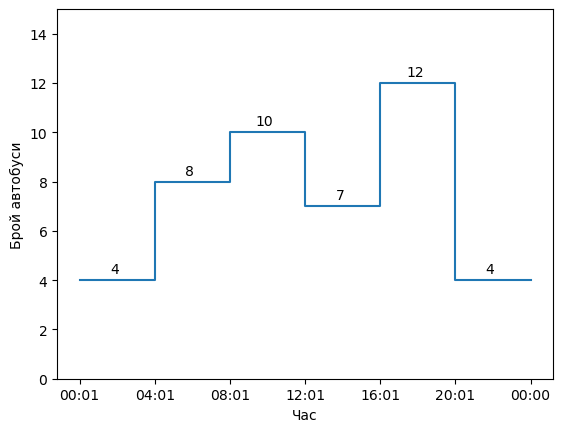

In [18]:
#| fold-code: true
#| label: fig-bus-schedule-graph
#| fig-cap: "График на натоварване на автобусите през деня"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create DataFrame
schedule_df = pd.DataFrame({
    'shift': ["00:01", "04:01", "08:01", "12:01", "16:01", "20:01", "00:00"],
    'demand': [4, 8, 10, 7, 12, 4, 4]
})

# Plot
plt.step(schedule_df['shift'], schedule_df['demand'], where='post')
plt.ylim(0, 15)
plt.xlabel('Час')
plt.ylabel('Брой автобуси')
for i, txt in enumerate(schedule_df['demand']):
    if i == len(schedule_df) - 1:
        continue

    plt.annotate(txt, (schedule_df['shift'][i], schedule_df['demand'][i]), textcoords="offset points", xytext=(25, 5),
                 ha='center')
plt.show()

:::{.callout-note collapse="true"}
## Математически модел

Променливи:

$$
x_{00}: \text{брой автобуси, които започват смяна в 00:01} \\
x_{04}: \text{брой автобуси, които започват смяна в 04:01} \\
x_{08}: \text{брой автобуси, които започват смяна в 08:01} \\
x_{12}: \text{брой автобуси, които започват смяна в 12:01} \\
x_{16}: \text{брой автобуси, които започват смяна в 16:01} \\
x_{20}: \text{брой автобуси, които започват смяна в 20:01}
$$

Целта на задачата е да намери минималния брой автобуси, които са необходими за обслужването на линията, т.е. сборът от всички автобуси, които са необходими за обслужването на линията, трябва да бъде минимален:

$$
\min x_{00} + x_{04} + x_{08} + x_{12} + x_{16} + x_{20}
$$

Ограничения:

1. Между 00:01 и 04:00 са необходими поне 4 автобуса. В този интервал ще се
движат автобусите, които започват смяна в 00:01 и 20:01 на предишния ден, тъй като смените продължават 8 часа.

$$
x_{20} + x_{00} \geq 4
$$

2. Между 04:01 и 08:00 са необходими поне 8 автобуса.

$$
x_{00} + x_{04} \geq 8
$$

3. Между 08:01 и 12:00 са необходими поне 10 автобуса.

$$
x_{04} + x_{08} \geq 10
$$

4. Между 12:01 и 16:00 са необходими поне 7 автобуса.

$$
x_{08} + x_{12} \geq 7
$$

5. Между 16:01 и 20:00 са необходими поне 12 автобуса.

$$
x_{12} + x_{16} \geq 12
$$

6. Между 20:01 и 00:00 са необходими поне 4 автобуса.

$$
x_{16} + x_{20} \geq 4
$$

:::

In [19]:
# Drop the last row as it is the same as the first one
sdf = schedule_df[:-1]

sdf.set_index('shift', inplace=True)
sdf

m = gp.Model("Bus Schedule")
# m.Params.LogToConsole = 0

# Create variables

shifts = m.addVars(sdf.index, name="Shifts", vtype=GRB.INTEGER)

# Set objective

m.setObjective(shifts.sum(), GRB.MINIMIZE)

# Set constraints

m.addConstrs(
    (
        shifts[idx] + shifts[sdf.index[i - 1]] >= sdf.loc[idx, "demand"] for i, idx in enumerate(sdf.index)
    ),
    name="Demand"
)

m.optimize()

m.write("bus_schedule.lp")
vars_df = pd.DataFrame(columns=['Variable', 'Value'], data=[(v.VarName, v.X) for v in m.getVars()])


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 20.04.6 LTS")

CPU model: 12th Gen Intel(R) Core(TM) i5-1235U, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 6 rows, 6 columns and 12 nonzeros
Model fingerprint: 0x65e7efa4
Variable types: 0 continuous, 6 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 1e+01]
Found heuristic solution: objective 26.0000000
Presolve time: 0.00s
Presolved: 6 rows, 6 columns, 12 nonzeros
Variable types: 0 continuous, 6 integer (0 binary)

Root relaxation: cutoff, 3 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0        26.00000   26.00000  0.00%     -    0s



In [20]:
vars_df

,Variable,Value
0,Shifts[00:01],0.0
1,Shifts[04:01],8.0
2,Shifts[08:01],2.0
3,Shifts[12:01],5.0
4,Shifts[16:01],7.0
5,Shifts[20:01],4.0


## Планиране на производство

Компания произвежда три вида зърнени закуски: A, B и C. Закуските се произвеждат от четири съставки: овесени ядки, стафиди, настъргани кокосови орехи и нарязани бадеми. 

- Продукт А е смес от овесени ядки, стафиди и бадеми в съотношение 50:5:2. 
- Продукт B е смес от овесени ядки, кокосови орехи и бадеми в съотношение 60:2:3.
- В продукт C са смесени овесени ядки, стафиди, кокосови орехи и бадеми в пропорция 60:3:4:2.
- Компанията продава продуктите за съответно 2.00 лв., 2.50 лв. и 3.00 лв. за кутия от 5 кг.
- Компанията трябва да задоволи минимално дневно търсене на A, B и C от 500, 600 и 400 кутии. 
- Компанията купува съставките за 100 лв./тон (овесени ядки), 120 лв./тон (стафиди), 110 лв./тон (кокосови орехи) и 200 лв./тон (бадеми).
- Доставките са ограничени до 5 тона на ден (овесени ядки), 2 тона (стафиди) и по един тон на ден за останалите две съставки (кокосови орехи, бадеми).

Съставете математически модел с който да препоръчате оптимален производствен план за тази компания. Целта на модела е да намери производствен план с най-висока стойност на печалбата на компанията.

:::{.callout-note collapse="true"}
## Математически модел

Към задачата можем да подходим по поне два начина в зависимост от избора на променливи.

И при двата подхода искаме да намерим максимума на печалбата, която е разликата от приходите, реализирани от продажба да продуктите и разходите за суровини (овесени ядки, стафиди и т.н.).


1. Нека $x_A, x_B, x_C$ са произведените количества от продуктите A, B и C в кг. Тогава целевата функция.

От описанието на съставките на трите продукта можем да изразим пропорциите на съставките в проценти от общото количество на продукта (@tbl-cereals-composition).

| Продукт/Съставка 	| Ов. ядки        	| Стафиди        	| Кокос          	| Бадеми         	|
|------------------	|-----------------	|----------------	|----------------	|----------------	|
| A                	| $\frac{50}{57}$ 	| $\frac{5}{57}$ 	| $0$ 	            | $\frac{2}{57}$ 	|
| B                	| $\frac{60}{65}$ 	| $0$              	| $\frac{2}{65}$ 	| $\frac{3}{65}$ 	|
| C                	| $\frac{60}{69}$ 	| $\frac{3}{69}$ 	| $\frac{4}{69}$ 	| $\frac{2}{69}$ 	|

: Състав на продуктите A, B и C {#tbl-cereals-composition}

При производството на един килограм от продукт A са необходими $\frac{50}{57}$ кг. овесени ядки, $\frac{5}{57}$ кг. стафиди и $\frac{2}{57}$ кг. бадеми. При производството на един килограм от продукт B са необходими $\frac{60}{65}$ кг. овесени ядки, $\frac{2}{65}$ кг. кокосови орехи и $\frac{3}{65}$ кг. бадеми. При производството на един килограм от продукт C са необходими $\frac{60}{69}$ кг. овесени ядки, $\frac{3}{69}$ кг. стафиди, $\frac{4}{69}$ кг. кокосови орехи и $\frac{2}{69}$ кг. бадеми.

Нека $y_{\text{овес}}, y_{\text{стафиди}}, y_{\text{кокос}}, y_{\text{бадеми}}$ са общо изразходваните количества на съставките в килограми.

От @tbl-cereals-composition можем да изведем използваните количества суровини при производството на $x_A, x_B$ и $x_C$ от продуктите.

$$
\begin{align*}
y_{\text{овес}} & = \frac{50}{57} x_{A} + \frac{60}{65} x_{B} + \frac{60}{69} x_{C} \\
y_{\text{стафиди}} & = \frac{5}{57} x_{A} + \frac{3}{69} x_{C} \\
y_{\text{кокос}} & = \frac{2}{65} x_{B} + \frac{4}{69} x_{C} \\
y_{\text{бадеми}} & = \frac{2}{57} x_{A} + \frac{3}{65} x_{B} + \frac{2}{69} x_{C}
\end{align*}
$$

Общите разходи за суровини са:

$$
Разходи = (100 y_{\text{овес}} + 120 y_{\text{стафиди}} + 110 y_{\text{кокос}} + 200 y_{\text{бадеми}}) / 1000
$$

Приходите от продажбата на продуктите са:

$$
(2.0 \cdot 500 x_{A} + 2.5 \cdot 500 x_{B} + 3.0 \cdot 500 x_{C}) / 5
$$

Печалбата (целевата функция в задачата) от продажбата на A, B и C е разликата между приходите от продажбата и разходите за производство.

$$
z = \text{Приходи} - \text{Разходи}
$$

В задачата има две групи ограничения:

1. Ограничения за минимални доставки

$$
\begin{align*}
x_{A} \geq 500 \cdot 2 \text{ (минимално производство на A в кг.)} \\
x_{B} \geq 600 \cdot 2  \text{ (минимално производство на B в кг.)} \\
x_{C} \geq 400 \cdot 2 \text{ (минимално производство на C в кг.)}
\end{align*}
$$

2. Ограничения за наличност на суровини

$$
\begin{align*}
y_{\text{овес}} & \leq 5 \cdot 1000 \text{ (овесени ядки в кг.)}\\
y_{\text{стафиди}} & \leq 2 \cdot 1000 \text{ (стафиди в кг.)}\\
y_{\text{кокос}} & \leq 1 \cdot 1000 \text{ (кокосови орехи в кг.)}\\
\end{align*}
$$

:::


:::{.callout-note collapse="true"}
## Математически модел (втори подход)

Възможен е и друг подход към задачата, който използва променливи за съставките на продуктите и изразява количествата произведени чрез тях.

Нека $x_{Aо}, x_{Aс}, x_{Aк}, x_{Aб}, x_{Bо}, x_{Bк}, x_{Bб}, x_{Cо}, x_{Cс}, x_{Cк}, x_{Cб}$ са количествата на съставките в килограми, които са използвани за производството на продуктите A, B и C.

$$
\begin{align*}
& x_{Aо}: \text{овесени ядки в продукт A, кг.} \\
& x_{Aс}: \text{стафиди в продукт A, кг.} \\
& x_{Aк}: \text{кокосови орехи в продукт A, кг.} \\
& x_{Aб}: \text{бадеми в продукт A, кг.} \\
& x_{Bо}: \text{овесени ядки в продукт B, кг.} \\
& x_{Bк}: \text{кокосови орехи в продукт B, кг.} \\
& x_{Bб}: \text{бадеми в продукт B, кг.} \\
& x_{Cо}: \text{овесени ядки в продукт C, кг.} \\
& x_{Cс}: \text{стафиди в продукт C, кг.} \\
& x_{Cк}: \text{кокосови орехи в продукт C, кг.} \\
& x_{Cб}: \text{бадеми в продукт C, кг.} \\
\end{align*}
$$

$$
\begin{align*}
x_A & = x_{Aо} + x_{Aс} + x_{Aк} + x_{Aб} \\
x_B & = x_{Bо} + x_{Bк} + x_{Bб} \\
x_C & = x_{Cо} + x_{Cс} + x_{Cк} + x_{Cб}
\end{align*}
$$


$$
\begin{align*}
y_{\text{oвес}} = x_{Aо} + x_{Bо} + x_{Cо} \\
y_{\text{стафиди}} = x_{Aс} + x_{Bс} + x_{Cс} \\
y_{\text{кокос}} = x_{Aк} + x_{Bк} + x_{Cк} \\
y_{\text{бадеми}} = x_{Aб} + x_{Bб} + x_{Cб}
\end{align*}
$$

Целевата функция е същата както и в предишния подход.

Различават се ограниченията за състава на продуктите.

$$
\begin{align*}
x_{Ao} = (50/5) x_{Aс} \\
x_{Ao} = (50/2) x_{Aб} \\
x_{Bо} = (60/2) x_{Bк} \\
x_{Bо} = (60/3) x_{Bб} \\
x_{Cо} = (60/3) x_{Cс} \\
x_{Cо} = (60/4) x_{Cк} \\
x_{Cо} = (60/2) x_{Cб} \\
\end{align*}
$$

Двата подхода се еквивалентни.
:::

In [21]:
import gurobipy as gp
from gurobipy import GRB

# Create a new model
m = gp.Model("Cereals")
m.Params.LogToConsole = 0

x_A = m.addVar(lb=0, name="x_A")
x_B = m.addVar(lb=0, name="x_B")
x_C = m.addVar(lb=0, name="x_C")

revenue = (2.0 * x_A + 2.5 * x_B + 3.0 * x_C) / 2.0

# For the costs we define the raw materials

y_oats = (50 / 57) * x_A + (60 / 65) * x_B + (60 / 69) * x_C
y_raisins = (5 / 57) * x_A + (3 / 69) * x_C
y_coconuts = (2 / 65) * x_B + (4 / 69) * x_C
y_almonds = (5 / 57) * x_A + (3 / 65) * x_B + (2 / 69) * x_C

costs = (100 * y_oats + 120 * y_raisins + 110 * y_coconuts + 200 * y_almonds) / 1000

# Set the objective function
m.setObjective(revenue - costs, GRB.MAXIMIZE)

# Minimum production constraints

m.addConstr(x_A >= 500 * 2, "MinA")
m.addConstr(x_B >= 600 * 2, "MinB")
m.addConstr(x_C >= 400 * 2, "MinC")

# Raw materials constraints

m.addConstr(y_oats <= 5 * 1000, "Oats")
m.addConstr(y_raisins <= 2 * 1000, "Raisins")
m.addConstr(y_coconuts <= 1 * 1000, "Coconuts")
m.addConstr(y_almonds <= 1 * 1000, "Almonds")

m.optimize()

print("Оптимална стойност на целевата функция: ", m.objVal)
print(f"Оптимален план: продукт A = {x_A.x:5.2f} кг., продукт B = {x_B.x:5.2f} кг., продукт C = {x_C.x:5.2f} кг.")

Оптимална стойност на целевата функция:  7097.561943319839
Оптимален план: продукт A = 1000.00 кг., продукт B = 1200.00 кг., продукт C = 3467.38 кг.


## Радиотерапия

При радиотерапия се използва радиация за лечение на рак. Целта на радиотерапията е да унищожи раковите клетки, като се опитва да се намали въздействието върху здравите тъкани. В този пример разглеждаме задача, в която имаме 6 лъча радиация, които се прилагат върху 9 групи тъкани. Всяка група тъкани може да облъчена от два лъча радиация (ляво и горе). Тъканите се различават по това, какво количество радиация ще получат при единица интензивност на всеки лъч. Тази информация е представена в  @tbl-radiation-therapy (и в друг формат в @tbl-radiation-therapy-pd), например при прилагане на една едицина интензивност при лъч 1, тъкан 1,1 ще получи 1 единица радиация, докато тъкан 1,2 ще получи 2 единици радиация.

|       |                      Лъч 4 |                      Лъч 5 |                      Лъч 6 |
|-------|---------------------------:|---------------------------:|---------------------------:|
| Лъч 1 |       [1/1]{color="green"} |   [2/1]{color="firebrick"} |       [2/1]{color="green"} |
| Лъч 2 |   [1/2]{color="firebrick"} |        [2/2]{color="blue"} | [2.5/2]{color="firebrick"} |
| Лъч 3 | [1.5/1]{color="firebrick"} | [1.5/1]{color="firebrick"} |     [2.5/1]{color="green"} |
: Тъкани и погълната радиация при единица интензивност на лъчите {#tbl-radiation-therapy}

Целта е здравите тъкани (в клетки 1,1; 1,2; 2,2; 3,3) да получат възможно най-малка доза радиация, докато в същото време болните тъкани трябва да
получат поне 7Gy (Грей), за да бъдат унищожени. Тъканта на гръбначния мозък (в клетка 2,2) е особено чувствителна и не трябва да
бъде изложена на радиация повече от 5Gy.

:::{.callout-note collapse="true"}
## Математически модел

$$
\begin{align*}
& \min (x_1 + x_4) + (2x_2 + 2x_5) + (2x_1 + x_6) + (2.5x_3 + x_6) = \\ 3x_1 + 2x_2 + 2.5x_3 + 2x_6 \\
& x_2 + 2x_4 \geq 7\\
& 1.5x_3 + x_4 \geq 7 \\
& 2x_1 + x_5 \geq 7 \\
& 1.5x_3 + x_5 \geq 7 \\
& 2.5x_2 + 2x_6 \geq 7 \\
& 2x_2 + 2x_5 \leq 5
\end{align*}
$$
:::


In [22]:
#| label: tbl-radiation-therapy-pd
#| tbl-cap: "Тъкани и погълната радиация при единица интензивност на лъчите (формат 2)"

import pandas as pd

dt = pd.DataFrame({
    "Страна 1": [1, 2, 2, 1, 2, 2.5, 1.5, 1.5, 2.5],
    "Страна 2": [1, 1, 1, 2, 2, 2, 1, 1, 1],
    "isCancer": [False, True, False, True, False, True, True, True, False],
    "isSpinal": [False, False, False, False, True, False, False, False, False]
}, index=pd.MultiIndex.from_product([range(1, 4), range(4, 7)]))
dt


Страна 1  Страна 2  isCancer  isSpinal
1 4       1.0         1     False     False
  5       2.0         1      True     False
  6       2.0         1     False     False
2 4       1.0         2      True     False
  5       2.0         2     False      True
  6       2.5         2      True     False
3 4       1.5         1      True     False
  5       1.5         1      True     False
  6       2.5         1     False     False

In [23]:
# Implementation 1

m = gp.Model("Radiation Therapy")

x = m.addVars([1, 2, 3, 4, 5, 6], name="x")

m.setObjective(
    x[1] + x[4] + 2 * x[2] + 2 * x[5] + 2 * x[1] + x[6] + 2.5 * x[3] + x[6], GRB.MINIMIZE
)

m.addConstr(
    x[2] + 2 * x[4] >= 7, "MinimalDoseCancer1"
)
m.addConstr(
    1.5 * x[3] + x[4] >= 7, "MinimalDoseCancer2"
)
m.addConstr(
    2 * x[1] + x[5] >= 7, "MinimalDoseCancer3"
)
m.addConstr(
    1.5 * x[3] + x[5] >= 7, "MinimalDoseCancer4"
)
m.addConstr(
    2.5 * x[2] + 2 * x[6] >= 7, "MinimalDoseCancer5"
)
m.addConstr(
    2 * x[2] + 2 * x[5] <= 5, "MaximalDoseSpinal"
)

m.optimize()

vars_df = pd.DataFrame(columns=['Variable', 'Value'], data=[(v.VarName, v.X) for v in m.getVars()])
constr_df = pd.DataFrame(columns=['Constraint', 'Shadow Price', 'Lower', 'Upper'],
                            data=[(c.ConstrName, c.Pi, c.SARHSLow, c.SARHSUp) for c in m.getConstrs()])
# m.write("radiation_impl1.lp")
vars_df


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 20.04.6 LTS")

CPU model: 12th Gen Intel(R) Core(TM) i5-1235U, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 6 rows, 6 columns and 12 nonzeros
Model fingerprint: 0xdff0d98c
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e+00, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 7e+00]
Presolve time: 0.01s
Presolved: 6 rows, 6 columns, 12 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.275000e+01   0.000000e+00      0s
       7    2.9750000e+01   0.000000e+00   0.000000e+00      0s

Solved in 7 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.975000000e+01


,Variable,Value
0,x[1],2.25
1,x[2],0.00
2,x[3],3.00
3,x[4],3.50
4,x[5],2.50
5,x[6],3.50


In [24]:
# Implementation 2

import gurobipy as gp
from gurobipy import GRB

m = gp.Model("Radiation Therapy")

# Create variables

idx_left = dt.index.get_level_values(0).drop_duplicates()
idx_upper = dt.index.get_level_values(1).drop_duplicates()

beams_left = m.addVars(idx_left, name="beam_left")
beams_upper = m.addVars(idx_upper, name="beam_upper")

# Set objective
# Radiation from the upper beams

rad_upper = gp.quicksum(
    dt.loc[(i, j), "Страна 2"] * beams_upper[j] for i, j in dt.index[~dt["isCancer"]])

rad_lower = gp.quicksum(
    dt.loc[(i, j), "Страна 1"] * beams_left[i] for i, j in dt.index[~dt["isCancer"]])

m.setObjective(rad_upper + rad_lower, GRB.MINIMIZE)

# Constraints

m.addConstrs(
    (
        dt.loc[(i, j), "Страна 1"] * beams_left[i] +
        dt.loc[(i, j), "Страна 2"] * beams_upper[j] >= 7
        for i, j in dt.index[dt["isCancer"]]
    ),
    name="MinimalDoseCancer"
)

# Maximal dose for the spinal cord

m.addConstrs(
    (
        dt.loc[(i, j), "Страна 1"] * beams_left[i] +
        dt.loc[(i, j), "Страна 2"] * beams_upper[j] <= 5
        for i, j in dt.index[dt["isSpinal"]]
    ),
    name="MaximalDoseSpinal"
)

m.optimize()

vars_df = pd.DataFrame(columns=['Variable', 'Value'], data=[(v.VarName, v.X) for v in m.getVars()])
constr_df = pd.DataFrame(columns=['Constraint', 'Shadow Price', 'Lower', 'Upper'],
                         data=[(c.ConstrName, c.Pi, c.SARHSLow, c.SARHSUp) for c in m.getConstrs()])
# m.write("radiation_impl2.lp")
vars_df


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 20.04.6 LTS")

CPU model: 12th Gen Intel(R) Core(TM) i5-1235U, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 6 rows, 6 columns and 12 nonzeros
Model fingerprint: 0x49b2e8be
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e+00, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 7e+00]
Presolve time: 0.00s
Presolved: 6 rows, 6 columns, 12 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.275000e+01   0.000000e+00      0s
       5    2.9750000e+01   0.000000e+00   0.000000e+00      0s

Solved in 5 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.975000000e+01


,Variable,Value
0,beam_left[1],2.25
1,beam_left[2],0.00
2,beam_left[3],3.00
3,beam_upper[4],3.50
4,beam_upper[5],2.50
5,beam_upper[6],3.50
